# Traffic Sign Classification

by Uki D. Lucas

** Self-Driving Car Engineer Nanodegree - Deep Learning **

# Overview

Design and implement a deep learning model that learns to recognize traffic signs. 

Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

**Table of Contents**

<div id="toc"></div>

---
# Set-up

## Hyper-parameters

I set the hyperparameters on top of the notebook for convenience of easy adjusting them

In [1]:
# Hyperparameters
# Arguments used for tf.truncated_normal, 
# which randomly defines variables for the weights and biases for each layer
mu = 0 # 0 seems
sigma = 0.1 # 0.1 seems good

EPOCHS = 200 # more the better, but longer, 6 achieve 98%
BATCH_SIZE = 256 #  OK larger is faster, memory limited
# on MacBook Pro 2.3GHz i7, 16GB 1600MHz DDR3 RAM: 
# 128 (slowest), 256 (faster), 512 (slower)
DROPOUT = 0.70 # 0.75
validation_split = 0.30 # we will use ~20% of TRAIN data for validation
best_model = "./model_0.884893309667"

In [2]:
import tensorflow as tf

In [3]:
from tqdm import tqdm
# tqdm shows a smart progress meter
# usage: tqdm(iterable)

## Load The Data

In [4]:
# Load pickled German street signs dataset from:
# http://bit.ly/german_street_signs_dataset
# If file location is not correct you get
# FileNotFoundError: [Errno 2] No such file or directory
training_file = "/Users/ukilucas/dev/DATA/traffic-signs-data/train.p" # 120.7MB
testing_file = "/Users/ukilucas/dev/DATA/traffic-signs-data/test.p" # 38.9 MB

import pickle

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
# Make sure the number of images in TRAIN set matches the number of labels
assert(len(X_train) == len(y_train))

# Make sure the number of images in TEST set matches the number of labels
assert(len(X_test) == len(y_test))

# name 'X_validation' is not defined
# assert(len(X_validation) == len(y_validation)) 

In [6]:
# print example of one image to see the dimentions of data
print()
print("Image Shape: {}".format(X_train[0].shape))
print()
# Image Shape: (32, 32, 3) - good for LeNet, no need for padding with zero


Image Shape: (32, 32, 3)



In [7]:
# print size of each set
training_set_size = len(X_train)
print("Training Set:   {} samples".format(training_set_size))
# Training Set:   39209 samples

testing_set_size = len(X_test)
print("Test Set:       {} samples".format(testing_set_size))
# Test Set:       12630 samples

#print("Validation Set: {} samples".format(len(X_validation)))

Training Set:   39209 samples
Test Set:       12630 samples


---

# Dataset Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

## Dataset Summary

MEETS SPECIFICATIONS:
Student performs basic data summary.

In [8]:
import numpy as np

In [9]:
### Replace each question mark with the appropriate value.
 
# TODO: Number of training examples
# Training Set:   39209 samples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
# Test Set:       12630 samples
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
# Image Shape: (32, 32, 3)
image_shape = X_test.shape[1:3]

input_image_size = 32
number_of_channels = 3 # trying to keep color

# TODO: How many unique classes/labels there are in the dataset.
# see signnames.csv 43 elements (0 to 42)
number_train_labels = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes (training labels) =", number_train_labels)

np.unique(y_train)

# Output:
# Number of training examples = 39209
# Number of testing examples = 12630
# Image data shape = (32, 32)
# Number of classes = 43

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes (training labels) = 43


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8)

## Exploratory Visualization

MEETS SPECIFICATIONS: 
Student performs an exploratory visualization on the dataset.

Overview:

Visualize the German Traffic Signs Dataset using the pickled file(s). 
This is open ended, suggestions include: plotting traffic sign images, 
plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, 
come back to it after you've completed the rest of the sections.

In [10]:
def human_readable_sign_names(sign_number):
    return {
        0: "Speed limit (20km/h)",
        1: "Speed limit (30km/h)",
        2: "Speed limit (50km/h)",
        3: "Speed limit (60km/h)",
        4: "Speed limit (70km/h)",
        5: "Speed limit (80km/h)",
        6: "End of speed limit (80km/h)",
        7: "Speed limit (100km/h)",
        8: "Speed limit (120km/h)",
        9: "No passing",
        10: "No passing for vehicles over 3.5 metric tons",
        11: "Right-of-way at the next intersection",
        12: "Priority road",
        13: "Yield",
        14: "Stop",
        15: "No vehicles",
        16: "Vehicles over 3.5 metric tons prohibited",
        17: "No entry",
        18: "General caution",
        19: "Dangerous curve to the left",
        20: "Dangerous curve to the right",
        21: "Double curve",
        22: "Bumpy road",
        23: "Slippery road",
        24: "Road narrows on the right",
        25: "Road work",
        26: "Traffic signals",
        27: "Pedestrians",
        28: "Children crossing",
        29: "Bicycles crossing",
        30: "Beware of ice/snow",
        31: "Wild animals crossing",
        32: "End of all speed and passing limits",
        33: "Turn right ahead",
        34: "Turn left ahead",
        35: "Ahead only",
        36: "Go straight or right",
        37: "Go straight or left",
        38: "Keep right",
        39: "Keep left",
        40: "Roundabout mandatory",
        41: "End of no passing",
        42: "End of no passing by vehicles over 3.5 metric tons"
    }.get(sign_number, "Error: sign not found") # default if x not found

# TEST function
print( human_readable_sign_names(0))
print( human_readable_sign_names(28))
print( human_readable_sign_names(42))
print( human_readable_sign_names(43))

Speed limit (20km/h)
Children crossing
End of no passing by vehicles over 3.5 metric tons
Error: sign not found


## Display sample images with corresponding labels

Please note the terrible quality of the images.

In this case, the **computer might be able to detect the right sign better than human eye**.

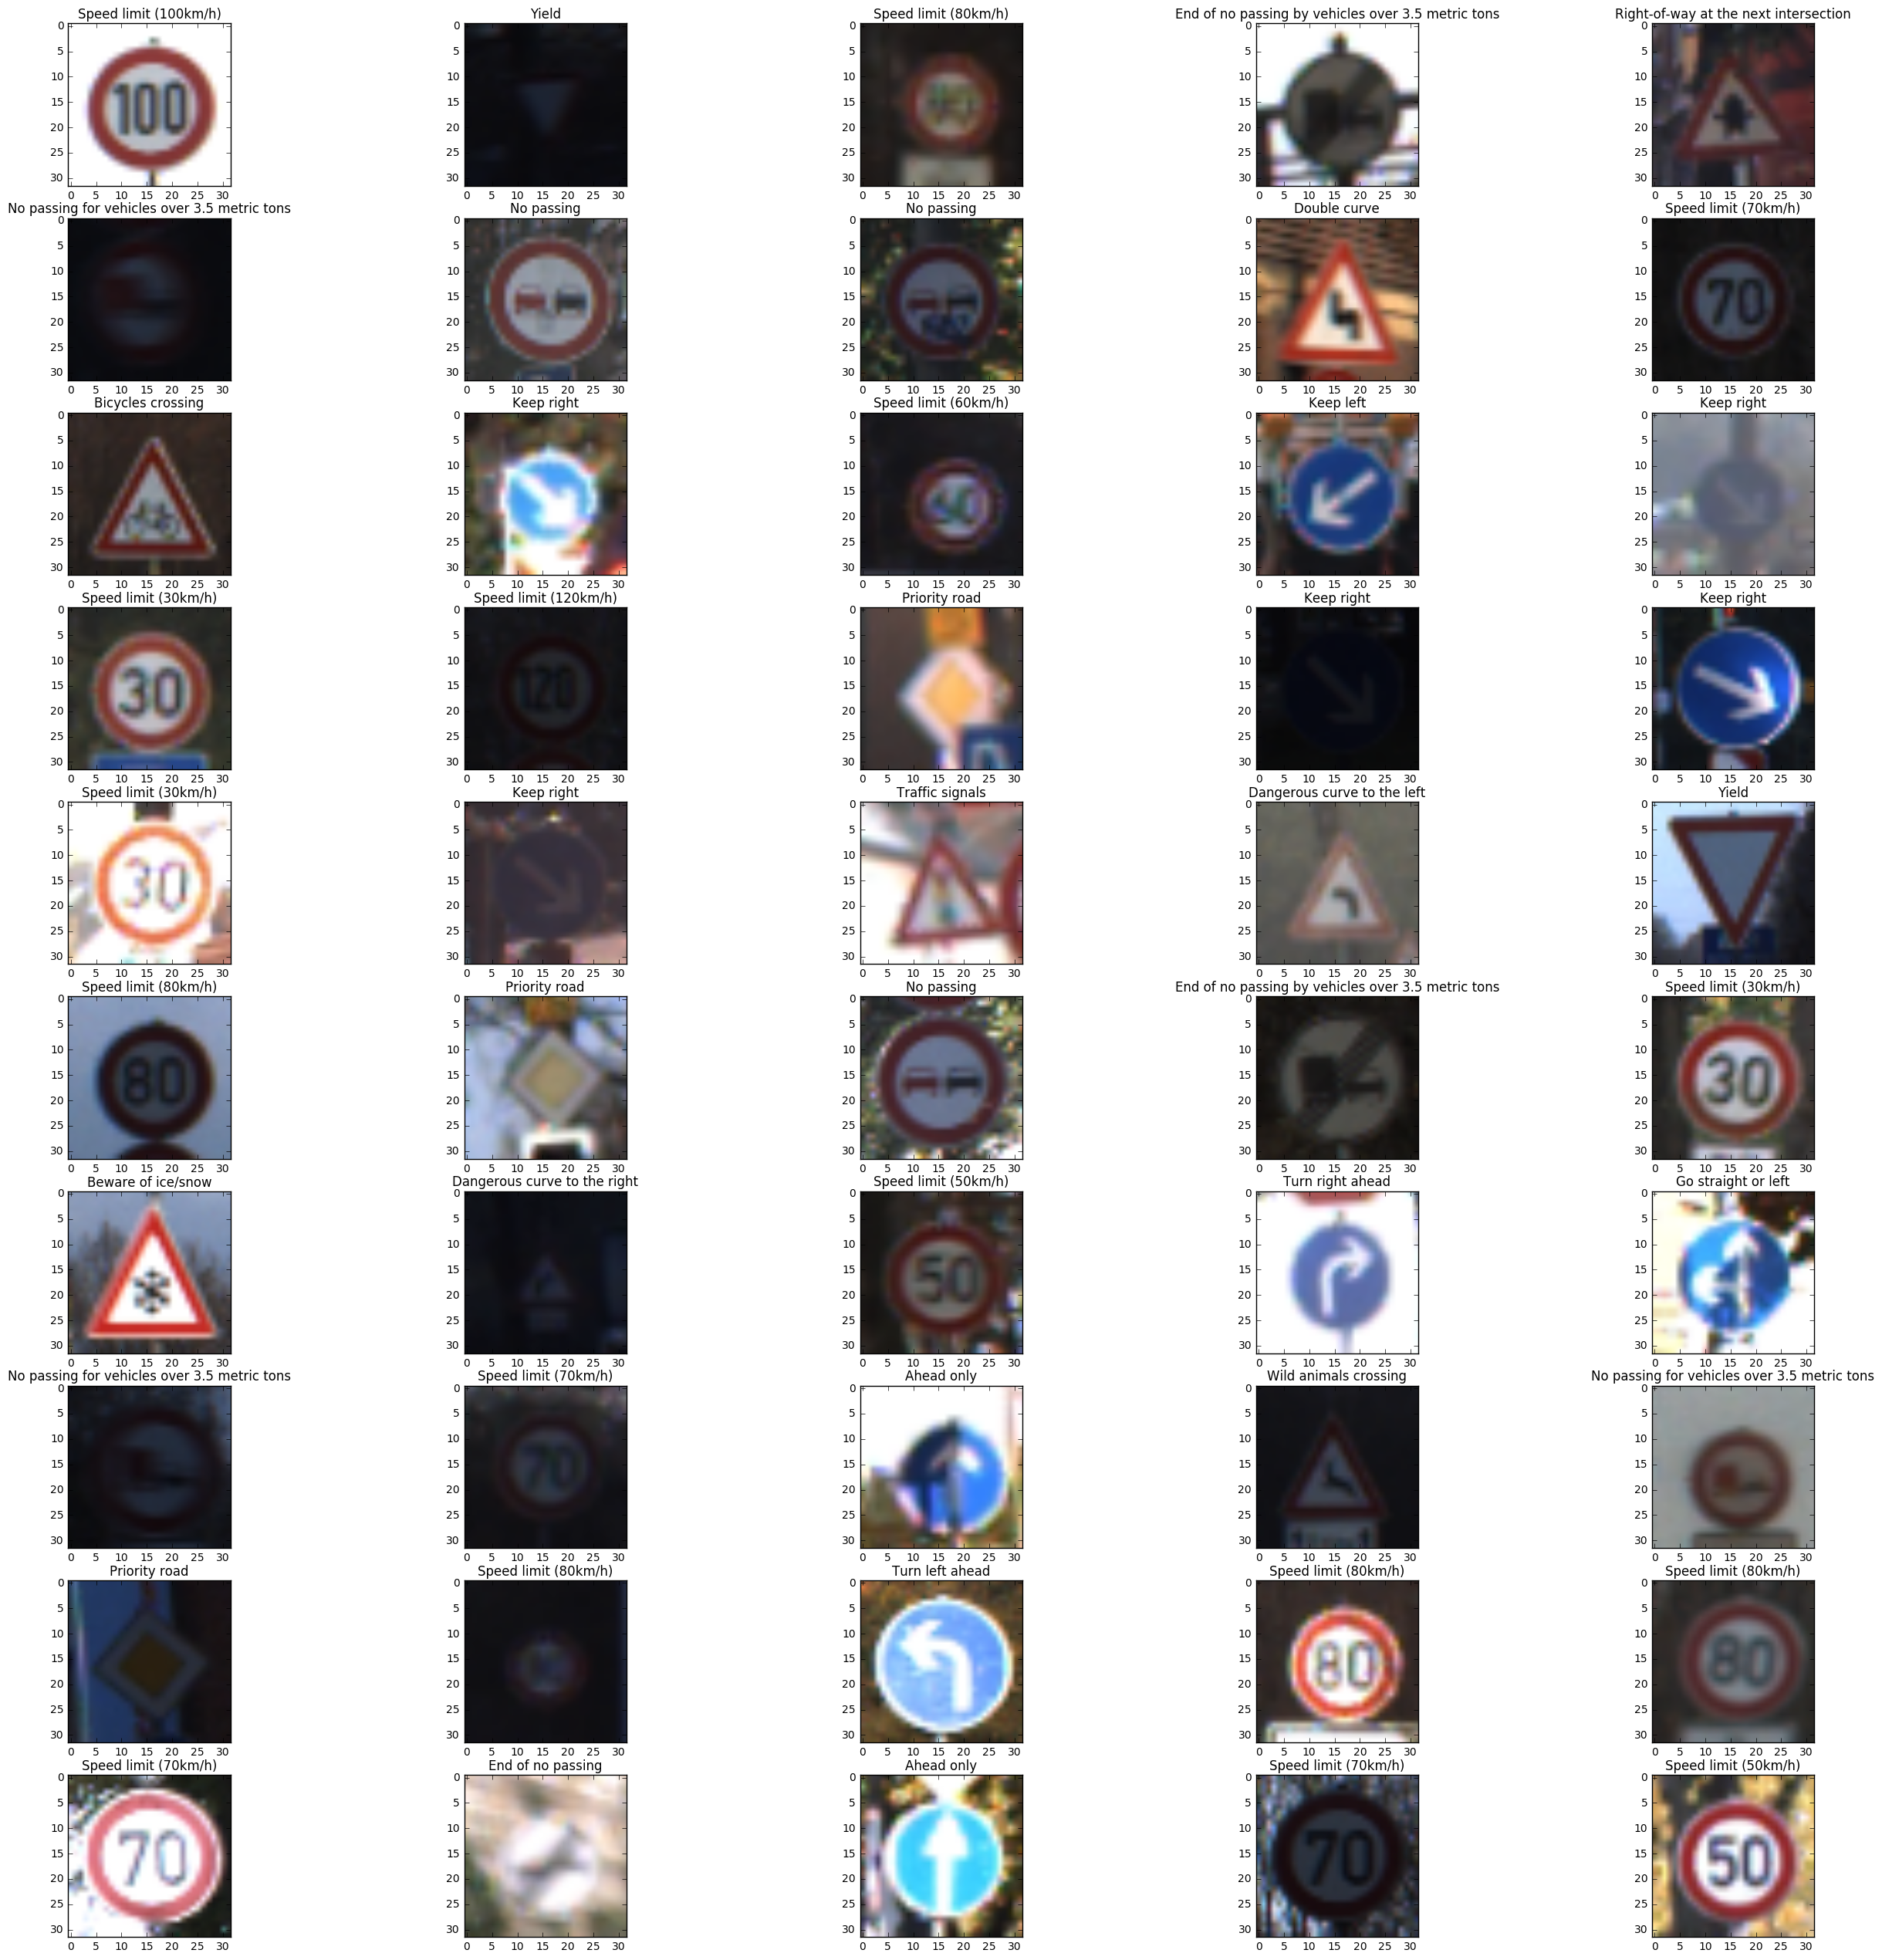

In [11]:
import random
# import numpy as np # already imported
import matplotlib.pyplot as plt
%matplotlib inline

figure, axes = plt.subplots(10, 5, figsize=(32,32))
for rows in range(10):
    for columns in range(5):
        index = random.randint(0, len(X_train))
        image = X_train[index]#.squeeze()

        axes[rows,columns].imshow(image)
        axes[rows,columns].set_title(human_readable_sign_names(y_train[index]))
plt.show()

### Training Data Labels Distribution

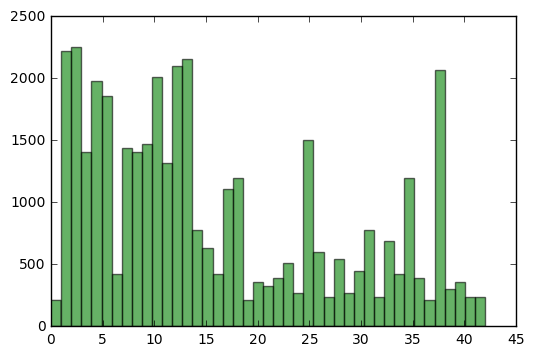

In [12]:
# train is the pickle file
histOut = plt.hist(train['labels'],number_train_labels, facecolor='g', alpha=0.60)

### Testing Data Labels Distribution

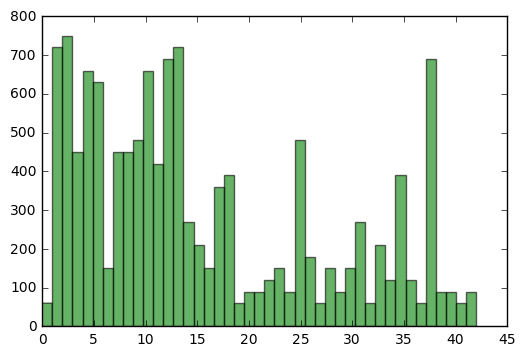

In [13]:
histOut = plt.hist(test['labels'],number_train_labels, facecolor='g', alpha=0.60)

---

# Design and Test a Model Architecture

## Preprocessing


<font color='red'>
Students provides sufficient details of the preprocessing techniques used. Additionally, the student discusses why the techniques were chosen.
</font>



#### Question 1 (preprocessing)

_Describe how you preprocessed the data. Why did you choose that technique?_

Answer:
- Shuffle given data each time to avoid image order ralated problems
- There is no need to resize the images as they are already 32x32
- I am keeping 3 color chanels as they should be beneficial in categorization
- image color depth scaling to values between -0.5 and +0.5
- Create validation set as 20% of the training set 

### Scale Image Color Depth from 0..255 to -0.5 to +0.5

In [14]:
def scale_image_color_depth(value):
    """ 
    normalizes image color depth values 0..255
    to values between -0.5 and +0.5
    """
    # image color depth has values 0 to 255
    max_value = 255.0
    # take the half value = 127.5
    return ((value - max_value/2) / max_value)

# TEST:
print("normalized", scale_image_color_depth(0)) # min value
print("normalized", scale_image_color_depth(128)) # half value
print("normalized", scale_image_color_depth(255)) # max value
    

normalized -0.5
normalized 0.00196078431372549
normalized 0.5


In [15]:
def scale_image_color_depth_for_all(image_set):
    results = np.copy(image_set) # create placeholder
    for i in tqdm(range(image_set.shape[0])):
        results[i] = scale_image_color_depth(image_set[i].astype(float))
    return results

### Histogram Equalization (even out brighness)

The effect should be that the images with little contrast should be very readable now.

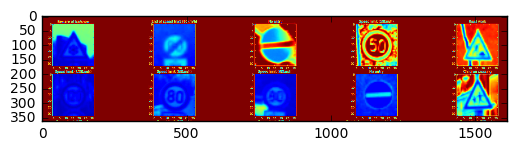

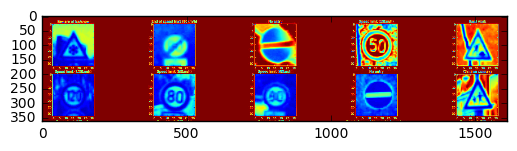

In [16]:
# http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
import cv2
import numpy as np
from matplotlib import pyplot as plt

def histogram_equalization(image):
    hist,bins = np.histogram(image.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()
    return image

def histogram_clahe(image):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(image)
    #cv2.imwrite('clahe_2.jpg',cl1)
    return cl1



image = cv2.imread('images/sample_set.jpg',0)
plt.imshow(image)
plt.show()
# histogram_equalization(image)
new_image = histogram_clahe(image)
plt.imshow(new_image)
plt.show()

## Preprocess image sets (scale, histogram)

In [17]:
# TRAIN FEATURES
# Apply histogram before changing color depth
# train_features = histogram_clahe(X_train.astype(float))
# Scale training set
train_features = scale_image_color_depth_for_all(X_train.astype(float))


# TEST FEATURES
# Apply histogram before changing color depth
# test_features = histogram_clahe(X_test.astype(float))
# Scale testing set
test_features = scale_image_color_depth_for_all(X_test.astype(float))

# TODO the application of histogram needs more love.

100%|██████████| 12630/12630 [00:00<00:00, 57300.16it/s]


### Create validation set as 20% of the training set

Use scaled values of the training set.

#### Question 2 (describe training, validation and testing)

<br/>
<font color='red'>
Student describes how the model was trained and evaluated. If the student generated additional data they discuss their process and reasoning. Additionally, the student discusses the difference between the new dataset with additional data, and the original dataset.
</font>

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
- sklearn.cross_validation  train_test_split
- create 20% validation set from the training features set
- assert that the number of features is same as corresponding labels
- display the count of each

In [18]:
from sklearn.cross_validation import train_test_split
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_validation, y_train, y_validation = train_test_split(train_features, 
                                                                y_train, 
                                                                test_size = validation_split, 
                                                                random_state=42)

In [19]:
# Make sure the number of images in TRAIN set matches the number of labels
assert(len(X_train) == len(y_train))
print("len(X_train)", len(X_train))

# Make sure the number of images in TEST set matches the number of labels
assert(len(X_test) == len(y_test))
print("len(X_test)", len(X_test))

# name 'X_validation' is not defined
assert(len(X_validation) == len(y_validation))
print("len(X_validation)", len(X_validation))

len(X_train) 27446
len(X_test) 12630
len(X_validation) 11763


In [20]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Features and Labels

- `x` is a placeholder for a batch of input images.
- `y` is a placeholder for a batch of output labels.

In [21]:
# x variable (Tensor) stores input batches
# None - later accepts batch of any size
# image dimentions 32x32x1
x = tf.placeholder(tf.float32, (None, 
                                input_image_size, 
                                input_image_size, 
                                number_of_channels)) # (None, 32, 32, 3)

# y variable (Tensor) stores labels
y = tf.placeholder(tf.int32, (None)) # if using "None,number_of_channels" -> (None, 3)


# encode our labels
one_hot_y = tf.one_hot(y, number_train_labels) # 43

# See definition of the DROPOUT below
keep_prob = tf.placeholder(tf.float32)

---
## Model Architecture

<font color='red'>
Student provides sufficient details of the characteristics and qualities of the architecture, such as the type of model used, the number of layers, the size of each layer. Visualizations emphasizing particular qualities of the architecture are encouraged.
</font>

### Convolutional Deep Neural Network

Implement the neural network architecture based on LeNet-5.


**Input **

The LeNet architecture accepts a 32x32xC number_color_channels. 

- MNIST images are grayscale, C is 1.
- German street sign images have **3 color channels**, C is 3.



#### Question 3: ( architecture of CDNN)

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer:**

CONVOLUTIONAL LAYER L1
- Calculated output size 28.0
- Convolution Output Tensor("add:0", shape=(?, 28, 28, 6), dtype=float32)
- ReLU Output Tensor("Relu:0", shape=(?, 28, 28, 6), dtype=float32)
- Pooling Layer Output Tensor("MaxPool:0", shape=(?, 14, 14, 6), dtype=float32)

CONVOLUTIONAL LAYER L2
- Calculated output size 28.0
- Convolution Output Tensor("add_1:0", shape=(?, 10, 10, 16), dtype=float32)
- ReLU Output Tensor("Relu_1:0", shape=(?, 10, 10, 16), dtype=float32)
- Pooling Layer Output Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)

FLATTENING LAYER L3
- Flattened Output Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)
- CONVOLUTIONAL FULLY CONNECTED LAYER L4
- Convolution Output Tensor("add_2:0", shape=(?, 120), dtype=float32)
- ReLU Output Tensor("Relu_2:0", shape=(?, 120), dtype=float32)

CONVOLUTIONAL FULLY CONNECTED LAYER L5
- Convolution Output Tensor("add_3:0", shape=(?, 84), dtype=float32)
- ReLU Output Tensor("Relu_3:0", shape=(?, 84), dtype=float32)

CONVOLUTIONAL FULLY CONNECTED LAYER L6
- Convolution Output Tensor("add_4:0", shape=(?, 43), dtype=float32)
- ReLU Output Tensor("Relu_4:0", shape=(?, 43), dtype=float32)


In [22]:
def convolution_output_size(input_size=32, filter_size=5, stride_veritcal=1):
    output_size = (input_size - filter_size + 1)/stride_veritcal
    print("Calculated output size", output_size)

In [23]:
def pooling_layer(input_tensor):
    # POOLING (SUBSAMPLING) LAYER L2
    # Input = 28x28x6. 
    # Output = 14x14x6.
    # value: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
    # ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor.
    # strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor.
    # padding: A string, either 'VALID' or 'SAME'. 
    # name: Optional name for the operation.
    tensor = tf.nn.max_pool(value = input_tensor, 
                           ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1], 
                           padding='VALID')
    print("Pooling Layer Output", tensor)
    #L2 output Tensor("L2:0", shape=(?, 14, 14, 6), dtype=float32)
    return tensor

In [24]:
def convolution_layer(input_tensor, filter_size=5, input_depth=3, output_depth=6):
    # L1 filter (5,5,3,6)
    # L2 filter (5,5,6,16) 
    
    filter_tensor = tf.Variable(tf.truncated_normal(
            shape=(filter_size, 
                   filter_size, 
                   input_depth, 
                   output_depth), 
            mean = mu, 
            stddev = sigma))
    
    bias = tf.Variable(tf.zeros(output_depth))
    tensor = tf.nn.conv2d(input = input_tensor, 
                         filter = filter_tensor, 
                         strides = [1, 1, 1, 1], 
                         padding='VALID'
                        ) + bias
    
    convolution_output_size(input_size=32, filter_size=filter_size, stride_veritcal=1)
    # calculated output size 28.0
    
    print("Convolution Output", tensor)
    # L1 output Tensor("add:0", shape=(?, 28, 28, 6), dtype=float32)
    
    # ReLU Activation function.
    tensor = tf.nn.relu(features = tensor)
    print("ReLU Activation funtion Output", tensor)
    # ReLU output Tensor("Relu:0", shape=(?, 28, 28, 6), dtype=float32)
    
    tensor = pooling_layer(input_tensor = tensor)
    return tensor

In [25]:
def convolution_fully_connected(input_tensor, input_size=400, output_size=120):
    # Fully Connected. Input = 400. Output = 120.
    filter_tensor = tf.Variable(tf.truncated_normal(
            shape=(input_size, output_size), 
            mean = mu, stddev = sigma))
    
    bias = tf.Variable(tf.zeros(output_size))
    
    tensor   = tf.matmul(input_tensor, filter_tensor) + bias
    print("Convolution Output", tensor)
    
    # ReLu Activation.
    tensor    = tf.nn.relu(tensor)
    print("ReLU Activation funtion Output", tensor)
    return tensor

In [26]:
from tensorflow.contrib.layers import flatten


    
def convolutional_neural_network(tensor): 

    print("CONVOLUTIONAL LAYER L1")
    tensor = convolution_layer(
        input_tensor = tensor, filter_size=5, input_depth=3, output_depth=6)
    
    print("CONVOLUTIONAL LAYER L2")
    tensor = convolution_layer(
        input_tensor = tensor, filter_size=5, input_depth=6, output_depth=16)

    # Input Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)
    print("FLATTENING LAYER L3")
    # Flattens Input 5x5x16 = 400
    tensor   = flatten(tensor)
    print("Flattened Output", tensor)
    
    # Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)
    
    print("CONVOLUTIONAL FULLY CONNECTED LAYER L4")
    tensor = convolution_fully_connected(input_tensor=tensor, input_size=400, output_size=120)
    # Convolution output tensor Tensor("add_2:0", shape=(?, 120), dtype=float32)
    # ReLU output tensor Tensor("Relu_2:0", shape=(?, 120), dtype=float32)
    
    print("CONVOLUTIONAL FULLY CONNECTED LAYER L5")
    tensor = convolution_fully_connected(input_tensor=tensor, input_size=120, output_size=84)
    # Convolution output tensor Tensor("add_3:0", shape=(?, 84), dtype=float32)
    #ReLU output tensor Tensor("Relu_3:0", shape=(?, 84), dtype=float32)
    
    print("CONVOLUTIONAL FULLY CONNECTED LAYER L6")
    tensor = convolution_fully_connected(input_tensor=tensor, input_size=84, output_size=43)
    # Convolution output tensor Tensor("add_4:0", shape=(?, 43), dtype=float32)
    # ReLU output tensor Tensor("Relu_4:0", shape=(?, 43), dtype=float32)
    
    return tensor # logits

## Dataset and Training

<font color='Purple'>
Student describes how the model was trained and evaluated. If the student generated additional data they discuss their process and reasoning. Additionally, the student discusses the difference between the new dataset with additional data, and the original dataset.
</font>

** Answer: **
- Run the training data through the training pipeline to train the model.
- Before each epoch, shuffle the training set.
- After each epoch, measure the loss and accuracy of the validation set.
- Save the model after training.

Create a training pipeline that uses the model to classify sign data.

In [27]:
logits = convolutional_neural_network(x)

CONVOLUTIONAL LAYER L1
Calculated output size 28.0
Convolution Output Tensor("add:0", shape=(?, 28, 28, 6), dtype=float32)
ReLU Activation funtion Output Tensor("Relu:0", shape=(?, 28, 28, 6), dtype=float32)
Pooling Layer Output Tensor("MaxPool:0", shape=(?, 14, 14, 6), dtype=float32)
CONVOLUTIONAL LAYER L2
Calculated output size 28.0
Convolution Output Tensor("add_1:0", shape=(?, 10, 10, 16), dtype=float32)
ReLU Activation funtion Output Tensor("Relu_1:0", shape=(?, 10, 10, 16), dtype=float32)
Pooling Layer Output Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)
FLATTENING LAYER L3
Flattened Output Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)
CONVOLUTIONAL FULLY CONNECTED LAYER L4
Convolution Output Tensor("add_2:0", shape=(?, 120), dtype=float32)
ReLU Activation funtion Output Tensor("Relu_2:0", shape=(?, 120), dtype=float32)
CONVOLUTIONAL FULLY CONNECTED LAYER L5
Convolution Output Tensor("add_3:0", shape=(?, 84), dtype=float32)
ReLU Activation funtion Output 

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

#### Softmax Cross Entropy

Cross Entropy is the measure of how different are 
the logits (output classes) from ground truth training labels

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
print(cross_entropy)

# average entropy from all the training images
mean_loss_tensor = tf.reduce_mean(cross_entropy)
print("mean_loss_tensor",mean_loss_tensor)



Tensor("Reshape_2:0", shape=(?,), dtype=float32)
mean_loss_tensor Tensor("Mean:0", shape=(), dtype=float32)


#### Question 4 (training, optimizer, batch size, epochs, params)

<font color='Purple'>
_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_
</font>

**Answer:**

#### Adam optimizer

This is a minimize the loss function (similar to Stockastic Gradient Decent SGD does)

AdamOptimizer is more sofisticated, so it is a good default.

It uses moving averages of the parameters (momentum); 
Bengio discusses the reasons for why this is beneficial in Section 3.1.1 of this paper. 

Simply put, this enables Adam to use a larger effective step size (rate), 
and the algorithm will converge to this step size without fine tuning

In [29]:
def print_hyper_parameters():
    print("- mu", mu)
    print("- sigma", sigma)
    print("- EPOCHS", EPOCHS, "more the better, but achieving > 98% is a proof") 
    print("- BATCH SIZE", BATCH_SIZE, "best results with 256 on my computer") 
    print("- DROPOUT", DROPOUT, "used for keep_prob") 
    
print_hyper_parameters()

- mu 0
- sigma 0.1
- EPOCHS 200 more the better, but achieving > 98% is a proof
- BATCH SIZE 256 best results with 256 on my computer
- DROPOUT 0.7 used for keep_prob


#### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [30]:
# learning rate (how quickly to update the networks weights)
rate = 0.001

adam_optimizer = tf.train.AdamOptimizer(learning_rate = rate)
print("adam_optimizer", adam_optimizer)

# uses backpropagation 
adam_optimizer_minimize = adam_optimizer.minimize(mean_loss_tensor)
print("adam_optimizer_minimize", adam_optimizer_minimize)

adam_optimizer <tensorflow.python.training.adam.AdamOptimizer object at 0x1185c85c0>
adam_optimizer_minimize name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/update_Variable_2/ApplyAdam"
input: "^Adam/update_Variable_3/ApplyAdam"
input: "^Adam/update_Variable_4/ApplyAdam"
input: "^Adam/update_Variable_5/ApplyAdam"
input: "^Adam/update_Variable_6/ApplyAdam"
input: "^Adam/update_Variable_7/ApplyAdam"
input: "^Adam/update_Variable_8/ApplyAdam"
input: "^Adam/update_Variable_9/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [31]:
# is prediction correct
are_preditions_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
print("are_preditions_correct", are_preditions_correct)

# calc model's overall accuracy by avegaring individual prediction acuracies 
predition_mean = tf.reduce_mean(tf.cast(are_preditions_correct, tf.float32))
print("predition_mean", predition_mean)


are_preditions_correct Tensor("Equal:0", dtype=bool)
predition_mean Tensor("Mean_1:0", dtype=float32)


In [32]:
def evaluate(X_data, y_data):
    num_examples = len(X_data) 
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(predition_mean, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [33]:
import time
start = time.time()

saver = tf.train.Saver()
vector_accurancies = []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print_hyper_parameters()
    print()
    for i in range(EPOCHS):
        # shuffle: make sure it is not biased by the order of images
        X_train, y_train = shuffle(X_train, y_train)
        
        # break training model into batches,
        # train the model on each batch
        for offset in range(0, training_set_size, BATCH_SIZE):
            end = offset + BATCH_SIZE
            # print("running batch from", offset, " step ", end, " up to ", training_set_size)
            batch_x = X_train[offset:end]
            batch_y = y_train[offset:end]
             
            sess.run(adam_optimizer_minimize, 
                     feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            
        # at the end of each epoch, evaluate against validation set
        validation_accuracy = evaluate(X_validation, y_validation)
        vector_accurancies.extend([validation_accuracy])
        print("EPOCH {} ...".format(i+1),
              "Validation Accuracy = {:.3f}".format(validation_accuracy))
        # EPOCH 1 ... Validation Accuracy = 0.300 - very low
        # EPOCH 2 ... Validation Accuracy = 0.500 - growing
        # training for 2 epochs and 256 batch size took 41.1 seconds
        print()
    
    end = time.time()
    print('Training for {} epochs and {} batch size took {} seconds'.format(
            EPOCHS, BATCH_SIZE, round(end - start,1)))
        
    # upon training complete, save it so we do not have to train again
    # assure to save the model with achieved accuracy,
    # this way later I can select the best run
    saver.save(sess, './model_' + str(validation_accuracy))
    print("Model saved")
    

Training...
- mu 0
- sigma 0.1
- EPOCHS 200 more the better, but achieving > 98% is a proof
- BATCH SIZE 256 best results with 256 on my computer
- DROPOUT 0.7 used for keep_prob



100%|██████████| 46/46 [00:02<00:00, 18.13it/s]


EPOCH 1 ... Validation Accuracy = 0.241



100%|██████████| 46/46 [00:02<00:00, 15.87it/s]


EPOCH 2 ... Validation Accuracy = 0.370



100%|██████████| 46/46 [00:02<00:00, 17.15it/s]


EPOCH 3 ... Validation Accuracy = 0.328



100%|██████████| 46/46 [00:02<00:00, 17.35it/s]


EPOCH 4 ... Validation Accuracy = 0.321



100%|██████████| 46/46 [00:02<00:00, 17.58it/s]


EPOCH 5 ... Validation Accuracy = 0.417



100%|██████████| 46/46 [00:02<00:00, 17.68it/s]


EPOCH 6 ... Validation Accuracy = 0.421



100%|██████████| 46/46 [00:02<00:00, 17.96it/s]


EPOCH 7 ... Validation Accuracy = 0.423



100%|██████████| 46/46 [00:02<00:00, 18.10it/s]


EPOCH 8 ... Validation Accuracy = 0.494



100%|██████████| 46/46 [00:02<00:00, 17.77it/s]


EPOCH 9 ... Validation Accuracy = 0.591



100%|██████████| 46/46 [00:02<00:00, 17.55it/s]


EPOCH 10 ... Validation Accuracy = 0.544



100%|██████████| 46/46 [00:02<00:00, 17.42it/s]


EPOCH 11 ... Validation Accuracy = 0.523



100%|██████████| 46/46 [00:02<00:00, 17.58it/s]


EPOCH 12 ... Validation Accuracy = 0.525



100%|██████████| 46/46 [00:02<00:00, 17.78it/s]


EPOCH 13 ... Validation Accuracy = 0.630



100%|██████████| 46/46 [00:02<00:00, 17.81it/s]


EPOCH 14 ... Validation Accuracy = 0.598



100%|██████████| 46/46 [00:02<00:00, 17.55it/s]


EPOCH 15 ... Validation Accuracy = 0.620



100%|██████████| 46/46 [00:02<00:00, 17.71it/s]


EPOCH 16 ... Validation Accuracy = 0.647



100%|██████████| 46/46 [00:02<00:00, 17.10it/s]


EPOCH 17 ... Validation Accuracy = 0.626



100%|██████████| 46/46 [00:02<00:00, 17.84it/s]


EPOCH 18 ... Validation Accuracy = 0.582



100%|██████████| 46/46 [00:02<00:00, 17.87it/s]


EPOCH 19 ... Validation Accuracy = 0.644



100%|██████████| 46/46 [00:02<00:00, 17.77it/s]


EPOCH 20 ... Validation Accuracy = 0.646



100%|██████████| 46/46 [00:02<00:00, 17.68it/s]


EPOCH 21 ... Validation Accuracy = 0.640



100%|██████████| 46/46 [00:02<00:00, 17.31it/s]


EPOCH 22 ... Validation Accuracy = 0.563



100%|██████████| 46/46 [00:02<00:00, 17.53it/s]


EPOCH 23 ... Validation Accuracy = 0.645



100%|██████████| 46/46 [00:02<00:00, 17.74it/s]


EPOCH 24 ... Validation Accuracy = 0.651



100%|██████████| 46/46 [00:02<00:00, 17.86it/s]


EPOCH 25 ... Validation Accuracy = 0.616



100%|██████████| 46/46 [00:02<00:00, 17.83it/s]


EPOCH 26 ... Validation Accuracy = 0.619



100%|██████████| 46/46 [00:02<00:00, 17.43it/s]


EPOCH 27 ... Validation Accuracy = 0.626



100%|██████████| 46/46 [00:02<00:00, 18.06it/s]


EPOCH 28 ... Validation Accuracy = 0.644



100%|██████████| 46/46 [00:02<00:00, 17.81it/s]


EPOCH 29 ... Validation Accuracy = 0.654



100%|██████████| 46/46 [00:02<00:00, 17.78it/s]


EPOCH 30 ... Validation Accuracy = 0.648



100%|██████████| 46/46 [00:02<00:00, 17.74it/s]


EPOCH 31 ... Validation Accuracy = 0.656



100%|██████████| 46/46 [00:02<00:00, 17.57it/s]


EPOCH 32 ... Validation Accuracy = 0.639



100%|██████████| 46/46 [00:02<00:00, 17.82it/s]


EPOCH 33 ... Validation Accuracy = 0.637



100%|██████████| 46/46 [00:02<00:00, 16.85it/s]


EPOCH 34 ... Validation Accuracy = 0.616



100%|██████████| 46/46 [00:02<00:00, 17.87it/s]


EPOCH 35 ... Validation Accuracy = 0.611



100%|██████████| 46/46 [00:02<00:00, 17.77it/s]


EPOCH 36 ... Validation Accuracy = 0.654



100%|██████████| 46/46 [00:02<00:00, 17.64it/s]


EPOCH 37 ... Validation Accuracy = 0.647



100%|██████████| 46/46 [00:02<00:00, 17.81it/s]


EPOCH 38 ... Validation Accuracy = 0.638



100%|██████████| 46/46 [00:02<00:00, 17.49it/s]


EPOCH 39 ... Validation Accuracy = 0.645



100%|██████████| 46/46 [00:02<00:00, 17.88it/s]


EPOCH 40 ... Validation Accuracy = 0.645



100%|██████████| 46/46 [00:02<00:00, 17.73it/s]


EPOCH 41 ... Validation Accuracy = 0.645



100%|██████████| 46/46 [00:02<00:00, 17.67it/s]


EPOCH 42 ... Validation Accuracy = 0.644



100%|██████████| 46/46 [00:02<00:00, 17.67it/s]


EPOCH 43 ... Validation Accuracy = 0.646



100%|██████████| 46/46 [00:02<00:00, 17.82it/s]


EPOCH 44 ... Validation Accuracy = 0.642



100%|██████████| 46/46 [00:02<00:00, 17.95it/s]


EPOCH 45 ... Validation Accuracy = 0.642



100%|██████████| 46/46 [00:02<00:00, 17.69it/s]


EPOCH 46 ... Validation Accuracy = 0.636



100%|██████████| 46/46 [00:02<00:00, 17.62it/s]


EPOCH 47 ... Validation Accuracy = 0.516



100%|██████████| 46/46 [00:02<00:00, 17.74it/s]


EPOCH 48 ... Validation Accuracy = 0.650



100%|██████████| 46/46 [00:02<00:00, 17.61it/s]


EPOCH 49 ... Validation Accuracy = 0.615



100%|██████████| 46/46 [00:02<00:00, 17.80it/s]


EPOCH 50 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.84it/s]


EPOCH 51 ... Validation Accuracy = 0.657



100%|██████████| 46/46 [00:02<00:00, 17.65it/s]


EPOCH 52 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.55it/s]


EPOCH 53 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:02<00:00, 18.00it/s]


EPOCH 54 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.75it/s]


EPOCH 55 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:02<00:00, 17.95it/s]


EPOCH 56 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.89it/s]


EPOCH 57 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:02<00:00, 17.78it/s]


EPOCH 58 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.98it/s]


EPOCH 59 ... Validation Accuracy = 0.655



100%|██████████| 46/46 [00:02<00:00, 18.01it/s]


EPOCH 60 ... Validation Accuracy = 0.636



100%|██████████| 46/46 [00:02<00:00, 17.99it/s]


EPOCH 61 ... Validation Accuracy = 0.561



100%|██████████| 46/46 [00:02<00:00, 17.63it/s]


EPOCH 62 ... Validation Accuracy = 0.606



100%|██████████| 46/46 [00:02<00:00, 17.39it/s]


EPOCH 63 ... Validation Accuracy = 0.655



100%|██████████| 46/46 [00:02<00:00, 17.02it/s]


EPOCH 64 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:02<00:00, 17.82it/s]


EPOCH 65 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.70it/s]


EPOCH 66 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:02<00:00, 17.61it/s]


EPOCH 67 ... Validation Accuracy = 0.611



100%|██████████| 46/46 [00:02<00:00, 17.63it/s]


EPOCH 68 ... Validation Accuracy = 0.632



100%|██████████| 46/46 [00:02<00:00, 17.69it/s]


EPOCH 69 ... Validation Accuracy = 0.652



100%|██████████| 46/46 [00:05<00:00,  9.08it/s]


EPOCH 70 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.86it/s]


EPOCH 71 ... Validation Accuracy = 0.656



100%|██████████| 46/46 [00:05<00:00,  8.24it/s]


EPOCH 72 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:05<00:00,  9.50it/s]


EPOCH 73 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:05<00:00,  8.41it/s]


EPOCH 74 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  7.95it/s]


EPOCH 75 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.07it/s]


EPOCH 76 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.23it/s]


EPOCH 77 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.32it/s]


EPOCH 78 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  9.17it/s]


EPOCH 79 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.60it/s]


EPOCH 80 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.60it/s]


EPOCH 81 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.49it/s]


EPOCH 82 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.68it/s]


EPOCH 83 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.42it/s]


EPOCH 84 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.44it/s]


EPOCH 85 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.93it/s]


EPOCH 86 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  9.14it/s]


EPOCH 87 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.52it/s]


EPOCH 88 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.36it/s]


EPOCH 89 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.30it/s]


EPOCH 90 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


EPOCH 91 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  9.03it/s]


EPOCH 92 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  9.02it/s]


EPOCH 93 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.69it/s]


EPOCH 94 ... Validation Accuracy = 0.652



100%|██████████| 46/46 [00:05<00:00,  8.54it/s]


EPOCH 95 ... Validation Accuracy = 0.630



100%|██████████| 46/46 [00:05<00:00,  9.09it/s]


EPOCH 96 ... Validation Accuracy = 0.654



100%|██████████| 46/46 [00:05<00:00,  9.31it/s]


EPOCH 97 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:05<00:00,  8.88it/s]


EPOCH 98 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.48it/s]


EPOCH 99 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.36it/s]


EPOCH 100 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.54it/s]


EPOCH 101 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.03it/s]


EPOCH 102 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.35it/s]


EPOCH 103 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.65it/s]


EPOCH 104 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.60it/s]


EPOCH 105 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  9.04it/s]


EPOCH 106 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.58it/s]


EPOCH 107 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.23it/s]


EPOCH 108 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  7.91it/s]


EPOCH 109 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  9.14it/s]


EPOCH 110 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  9.03it/s]


EPOCH 111 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  9.03it/s]


EPOCH 112 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.97it/s]


EPOCH 113 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.31it/s]


EPOCH 114 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  7.99it/s]


EPOCH 115 ... Validation Accuracy = 0.590



100%|██████████| 46/46 [00:05<00:00,  8.41it/s]


EPOCH 116 ... Validation Accuracy = 0.479



100%|██████████| 46/46 [00:05<00:00,  8.16it/s]


EPOCH 117 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:05<00:00,  8.60it/s]


EPOCH 118 ... Validation Accuracy = 0.656



100%|██████████| 46/46 [00:05<00:00,  9.06it/s]


EPOCH 119 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.90it/s]


EPOCH 120 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.85it/s]


EPOCH 121 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.55it/s]


EPOCH 122 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.48it/s]


EPOCH 123 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  7.91it/s]


EPOCH 124 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.04it/s]


EPOCH 125 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.57it/s]


EPOCH 126 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  9.20it/s]


EPOCH 127 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.85it/s]


EPOCH 128 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  9.17it/s]


EPOCH 129 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.78it/s]


EPOCH 130 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.53it/s]


EPOCH 131 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.35it/s]


EPOCH 132 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.96it/s]


EPOCH 133 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  9.10it/s]


EPOCH 134 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.47it/s]


EPOCH 135 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.90it/s]


EPOCH 136 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.22it/s]


EPOCH 137 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.33it/s]


EPOCH 138 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.45it/s]


EPOCH 139 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.34it/s]


EPOCH 140 ... Validation Accuracy = 0.615



100%|██████████| 46/46 [00:05<00:00,  8.94it/s]


EPOCH 141 ... Validation Accuracy = 0.641



100%|██████████| 46/46 [00:05<00:00,  8.83it/s]


EPOCH 142 ... Validation Accuracy = 0.648



100%|██████████| 46/46 [00:05<00:00,  8.85it/s]


EPOCH 143 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.32it/s]


EPOCH 144 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  7.58it/s]


EPOCH 145 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.29it/s]


EPOCH 146 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.62it/s]


EPOCH 147 ... Validation Accuracy = 0.659



100%|██████████| 46/46 [00:05<00:00,  8.74it/s]


EPOCH 148 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.76it/s]


EPOCH 149 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.72it/s]


EPOCH 150 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.25it/s]


EPOCH 151 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.27it/s]


EPOCH 152 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.09it/s]


EPOCH 153 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.02it/s]


EPOCH 154 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  9.11it/s]


EPOCH 155 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.71it/s]


EPOCH 156 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.71it/s]


EPOCH 157 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.35it/s]


EPOCH 158 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.54it/s]


EPOCH 159 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.22it/s]


EPOCH 160 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.57it/s]


EPOCH 161 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.79it/s]


EPOCH 162 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  9.18it/s]


EPOCH 163 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  7.95it/s]


EPOCH 164 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.44it/s]


EPOCH 165 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.29it/s]


EPOCH 166 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.82it/s]


EPOCH 167 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.82it/s]


EPOCH 168 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.78it/s]


EPOCH 169 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  7.82it/s]


EPOCH 170 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.35it/s]


EPOCH 171 ... Validation Accuracy = 0.649



100%|██████████| 46/46 [00:05<00:00,  8.39it/s]


EPOCH 172 ... Validation Accuracy = 0.653



100%|██████████| 46/46 [00:05<00:00,  8.11it/s]


EPOCH 173 ... Validation Accuracy = 0.591



100%|██████████| 46/46 [00:05<00:00,  8.79it/s]


EPOCH 174 ... Validation Accuracy = 0.655



100%|██████████| 46/46 [00:05<00:00,  8.81it/s]


EPOCH 175 ... Validation Accuracy = 0.658



100%|██████████| 46/46 [00:05<00:00,  8.86it/s]


EPOCH 176 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.41it/s]


EPOCH 177 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  8.52it/s]


EPOCH 178 ... Validation Accuracy = 0.660



100%|██████████| 46/46 [00:05<00:00,  7.28it/s]


EPOCH 179 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.88it/s]


EPOCH 180 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.68it/s]


EPOCH 181 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.81it/s]


EPOCH 182 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


EPOCH 183 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.57it/s]


EPOCH 184 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.62it/s]


EPOCH 185 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.05it/s]


EPOCH 186 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.91it/s]


EPOCH 187 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  7.56it/s]


EPOCH 188 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.51it/s]


EPOCH 189 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.15it/s]


EPOCH 190 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.17it/s]


EPOCH 191 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.20it/s]


EPOCH 192 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.14it/s]


EPOCH 193 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.32it/s]


EPOCH 194 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.52it/s]


EPOCH 195 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.88it/s]


EPOCH 196 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  9.01it/s]


EPOCH 197 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  9.12it/s]


EPOCH 198 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:05<00:00,  8.43it/s]


EPOCH 199 ... Validation Accuracy = 0.661



100%|██████████| 46/46 [00:06<00:00,  7.22it/s]


EPOCH 200 ... Validation Accuracy = 0.661

Training for 200 epochs and 256 batch size took 6846.8 seconds
Model saved


## Learning accuracy graph

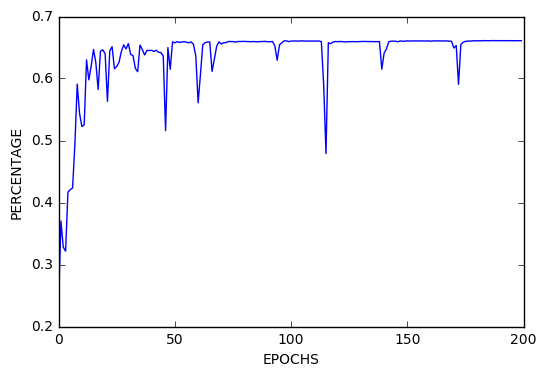

In [34]:
import matplotlib.pyplot as plt
plt.plot(vector_accurancies)
plt.xlabel('EPOCHS')
plt.ylabel('PERCENTAGE')
plt.show()

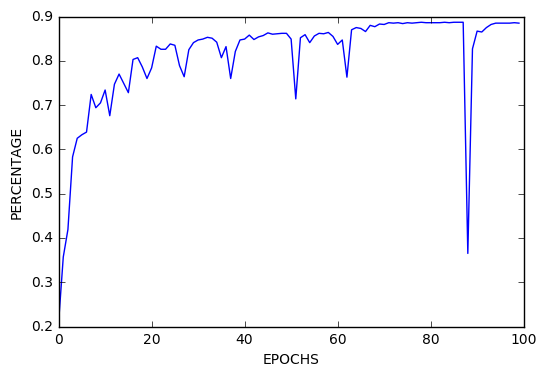

In [35]:


# Example Run 100 epochs
vector_accurancies  = [ 0.210, 0.357, 0.419, 0.583, 0.625, 0.633, 0.639, 
                       0.724, 0.694, 0.705, 0.734, 0.676, 0.747, 0.770, 
                       0.749, 0.728, 0.803, 0.807, 0.786, 0.760, 0.784, 
                       0.833, 0.826, 0.826, 0.838, 0.835, 0.789, 0.764, 
                       0.825, 0.841, 0.847, 0.849, 0.853, 0.851, 0.842, 
                       0.807, 0.832, 0.760, 0.821, 0.847, 0.849, 0.858, 
                       0.848, 0.854, 0.857, 0.863, 0.860, 0.861, 0.862, 
                       0.862, 0.849, 0.714, 0.852, 0.859, 0.841, 0.856, 
                       0.862, 0.861, 0.864, 0.855, 0.837, 0.847, 0.763, 
                       0.870, 0.875, 0.873, 0.866, 0.880, 0.877, 0.883, 
                       0.882, 0.886, 0.885, 0.886, 0.884, 0.886, 0.885, 
                       0.886, 0.887, 0.886, 0.886, 0.886, 0.886, 0.887, 
                       0.886, 0.887, 0.887, 0.887, 0.365, 0.827, 0.867, 
                       0.865, 0.875, 0.882, 0.885, 0.885, 0.885, 0.885, 
                       0.886, 0.885]

import matplotlib.pyplot as plt
plt.plot(vector_accurancies)
plt.xlabel('EPOCHS')
plt.ylabel('PERCENTAGE')
plt.show()

### Question 5

<font color='Purple'>
_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._
</font>

**Answer:**

- I have started with LeNet architecture as is was recommended in class
- Made sure it runs on MINST dataset
- Made sure to change it to German signs (32x32x3)
- Stepped thru each piece of functionality, refactored names, functions  to understand it better
- Looked up most of the functions in TensorFlow official documentation
- Started to play with Hyper-parameters to get better results
- I am not good enough yet to start switching the architecture



Training...
- mu 0
- sigma 0.3
- EPOCHS 100 more the better, but achieving > 98% is a proof
- BATCH SIZE 512 best results with 256 on my computer
- DROPOUT 0.8 used for keep_prob

100%|██████████| 16/16 [00:03<00:00,  4.91it/s]
EPOCH 1 ... Validation Accuracy = 0.181


100%|██████████| 16/16 [00:01<00:00,  8.14it/s]
EPOCH 97 ... Validation Accuracy = 0.803

100%|██████████| 16/16 [00:02<00:00,  7.70it/s]
EPOCH 98 ... Validation Accuracy = 0.802

100%|██████████| 16/16 [00:01<00:00,  8.09it/s]
EPOCH 99 ... Validation Accuracy = 0.803

100%|██████████| 16/16 [00:02<00:00,  7.89it/s]
EPOCH 100 ... Validation Accuracy = 0.803

Training for 100 epochs and 512 batch size took 3649.5 seconds
Model saved

---
# Evaluate saved model agaist the TEST set

In [36]:
# I will be updating the model name to the HIGHEST accurancy achieved

with tf.Session() as sess:
    print ('Re-loading saved model' + best_model)
    saver.restore(sess,   best_model)

    test_accuracy = evaluate(X_test, y_test)
    print("Evaluating the TEST set agaist restored model trained to 88.4%, result = {:.1f}% accurancy".format(test_accuracy*100))

Re-loading saved model./model_0.884893309667


100%|██████████| 50/50 [00:06<00:00,  8.02it/s]

Evaluating the TEST set agaist restored model trained to 88.4%, result = 68.2% accurancy


---

# Test a Model on New Images



#### Question 6 (choose and describe 5 new images)

<font color='Purple'>
Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.


_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

</font>


**Answer**

- I found 7 signs that indicate 23: "Slippery road",
- I think they are a VERY IMTERESTING test as each is a little different
- I resized each to square
- I created a notebook with code to resize whole directory of images, see same folder
- I resized each to 32x32 - the QUALITY IS TERRIBLE
- Image slip_008_32x32.png is from the TRAINING set to see if it will be guessed

I do not understand why we use such a bad training set of 32x32 images, 
it makes sense for characted recognition, but not for signs with important text inside.

### Show NEW images (original and resized 32x32)

In [37]:
directory = "images/verification"
prepended_by = "slip_"


import os
listing = os.listdir(directory)
print (len(listing))
listing[5]

18


'slip_003.jpg'

ignoring .DS_Store


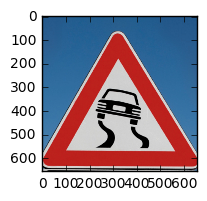

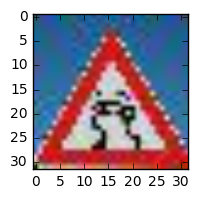

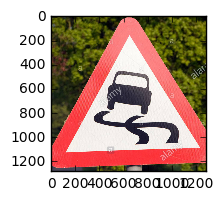

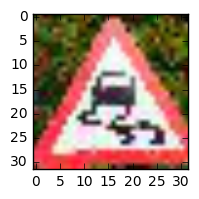

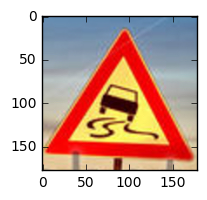

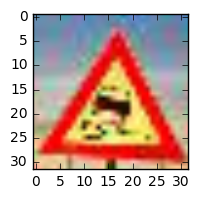

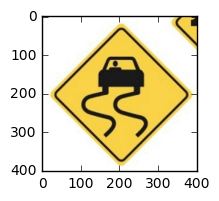

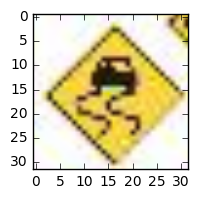

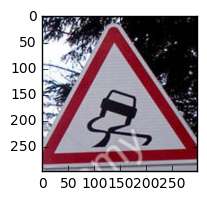

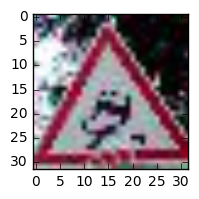

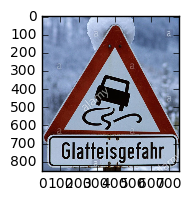

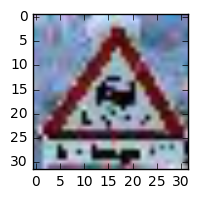

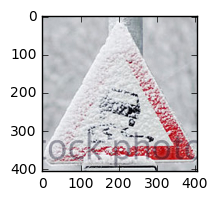

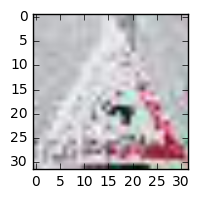

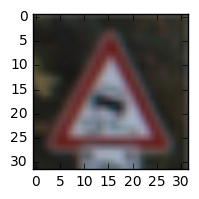

ignoring stop.jpg
ignoring stop_32x32.jpg


In [38]:
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
 

# count and display valid images
counter = 0
for i in range(len(listing)):
    if ".jpg" not in listing[i]: 
        print("ignoring", listing[i])
        continue
    if prepended_by not in listing[i]: 
        print("ignoring", listing[i])
        continue
        
    image = io.imread(directory + "/" + listing[i])
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.show()
    
    if "32x32" in listing[i]: 
        counter = counter + 1
        


In [39]:
print("counter", counter)      
image_matrix = np.uint8(np.zeros((counter, 32, 32, 3))) 
print("image_matrix", image_matrix.shape)

index = -1
for i in range(len(listing)):
    if ".jpg" not in listing[i]: 
        print("ignoring", listing[i])
        continue
    if prepended_by not in listing[i]: 
        print("ignoring", listing[i])
        continue

    if "32x32" in listing[i]: 
        image = io.imread(directory + "/" + listing[i])
        index = index + 1
        image_matrix[index] = image
        print("adding", listing[i], "@ index", index)
image_matrix.shape

counter 8
image_matrix (8, 32, 32, 3)
ignoring .DS_Store
adding slip_001_32x32.jpg @ index 0
adding slip_002_32x32.jpg @ index 1
adding slip_003_32x32.jpg @ index 2
adding slip_004_32x32.jpg @ index 3
adding slip_005_32x32.jpg @ index 4
adding slip_006_32x32.jpg @ index 5
adding slip_007_32x32.jpg @ index 6
adding slip_008_32x32.jpg @ index 7
ignoring stop.jpg
ignoring stop_32x32.jpg


(8, 32, 32, 3)

#### Question 7 (performance of new images)

<font color='Purple'>
Student documents the performance of the model when tested on the captured images and compares it to the results of testing on the dataset.
</font>


_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

- I created image_matrix with 7 of my NEW #23: "Slippery road"
- I preprocess them the same way as training set, I got new_images
- I created lables (all same): new_labels = [23, 23, 23, 23, 23, 23, 23]
- I run evaluate function (test set returned 0.682)
- My set of NEW images returned 0% accurancy (disappointing)
- I cannot explain this, considering that I had 1 image from training set

In [40]:
items = len(image_matrix)
print("Number of new images:", items)

Number of new images: 8


In [41]:
new_images = scale_image_color_depth_for_all(
    image_matrix.reshape((-1, 32, 32, 3)).astype(float))

new_labels =  [23] * items
print(new_labels)
human_readable_sign_names(23)

100%|██████████| 8/8 [00:00<00:00, 4390.79it/s]

[23, 23, 23, 23, 23, 23, 23, 23]


'Slippery road'

In [42]:
# I will be updating the model name to the HIGHEST accurancy achieved

with tf.Session() as sess:
    print ('Re-loading saved model' + best_model)
    saver.restore(sess,   best_model)

    test_accuracy = evaluate(new_images, new_labels)
    print("Evaluating the TEST set agaist restored model trained to 88.4%, result = {:.1f}% accurancy".format(test_accuracy*100))

Re-loading saved model./model_0.884893309667


100%|██████████| 1/1 [00:00<00:00, 68.45it/s]

Evaluating the TEST set agaist restored model trained to 88.4%, result = 0.0% accurancy


#### Question 8 (visualize softmax on new images)

<font color='Purple'>
The softmax probabilities of the predictions on the captured images are visualized. The student discusses how certain or uncertain the model is of its predictions.
</font>

** Answer: **
- Predition is totally misleading
- For some there is 100%, for other 20%
- It is hard to draw any conclusion

In [43]:
softmax_tensor = tf.nn.softmax(logits)

def classify_images(X_data):
    session = tf.get_default_session()
    predicted_tensor = session.run(softmax_tensor, feed_dict={x: X_data, keep_prob: 0.8})
    return predicted_tensor
    
with tf.Session() as sess:
    print ('Re-loading saved model' + best_model)
    saver.restore(sess,   best_model)
    
    predictions = classify_images(new_images)
    top_k_tensor = sess.run(tf.nn.top_k(predictions, 5, sorted=True))
    label_indexes = np.argmax(top_k_tensor, 1)

values = label_indexes[1,1:]  

for index in tqdm(range(len(values))):
    print(human_readable_sign_names(values[index]), values[index])

Re-loading saved model./model_0.884893309667


100%|██████████| 4/4 [00:00<00:00, 6136.51it/s]

Speed limit (30km/h) 1
Speed limit (50km/h) 2
Speed limit (50km/h) 2
Speed limit (50km/h) 2


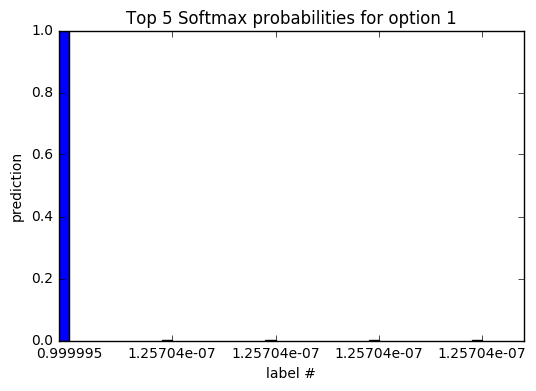

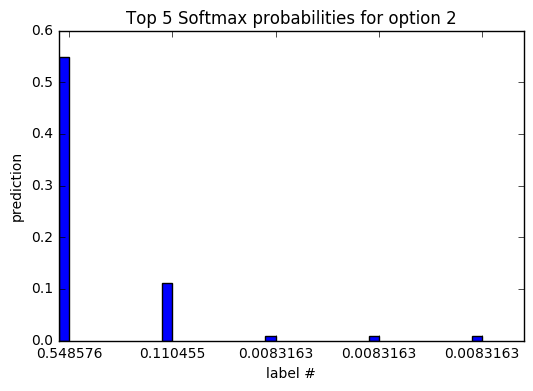

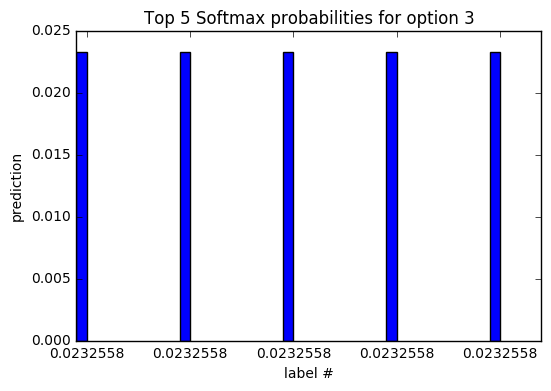

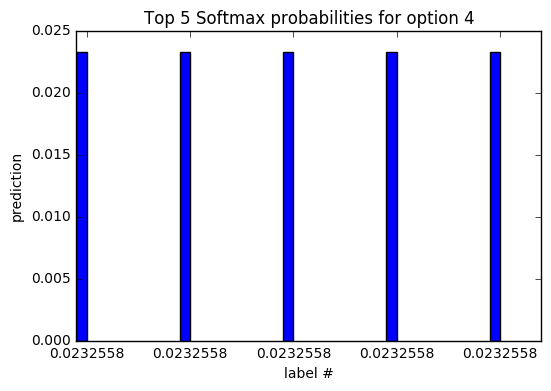

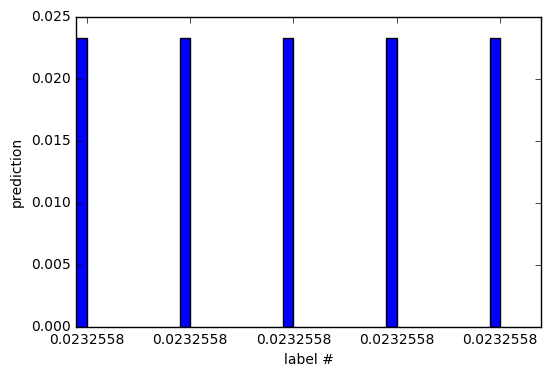

In [44]:
### Visualize the softmax probabilities
top = 5

for i in range(top):
    predictions = top_k_tensor[0][i]
    plt.title('Top {} Softmax probabilities for option {}'.format(top, str(i)))
    plt.figure(i)
    plt.xlabel('label #')
    plt.ylabel('prediction')
    plt.bar(range(top), predictions, 0.10, color='b')
    plt.xticks(np.arange(top) + 0.10, tuple(predictions))

plt.show()

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.